# Customer Purchase Value Prediction

This notebook aims to predict customer purchase values based on their multi-session behavior across digital touchpoints. We'll analyze user interactions including browser types, traffic sources, device details, and geographical indicators to estimate purchase potential and optimize marketing strategies.

## 1. Required Libraries

First, let's import all the necessary libraries for our analysis.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

## 2. Load and Explore Dataset

Let's load the training and testing datasets and examine their basic properties.

In [17]:
# Load the datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

# Display basic information about the training data
print('Training Data Shape:', train_data.shape)
print('\nBasic Information:')
train_data.info()

print('\nFirst few rows of the training data:')
train_data.head()

Training Data Shape: (116023, 52)

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.0,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,61421,(not set),not available in demo dataset,domain1,0,not available in demo dataset,1,not available in demo dataset,Washington,youtube.com,1,not available in demo dataset,1500100799,Windows,Northern America,referral,NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Redmond,NaN,Seattle-Tacoma WA,1.0,8,not available in demo dataset,/intl/hr/yt/about/,1.0,20170714,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.0
1,True,0.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,72287,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,California,(direct),1,not available in demo dataset,1495262065,Macintosh,Northern America,(none),NaN,not available in demo dataset,United States,not available in demo dataset,NaN,Not Socially Engaged,Mountain View,NaN,San Francisco-Oakland-San Jose CA,1.0,8,not available in demo dataset,NaN,1.0,20170519,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.0
2,True,0.0,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,not available in demo dataset,25180,(not set),not available in demo dataset,domain1,0,not available in demo dataset,2,not available in demo dataset,Lombardy,google,1,not available in demo dataset,1508510328,Windows,Southern Europe,organic,NaN,not available in demo dataset,Italy,not available in demo dataset,NaN,Not Socially Engaged,Milan,NaN,(not set),6.0,8,not available in demo dataset,NaN,NaN,20171020,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.0,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,not available in demo dataset,41295,(not set),not available in demo dataset,domain3,0,not available in demo dataset,1,not available in demo dataset,not available in demo dataset,youtube.com,1,not available in demo dataset,1483431838,Windows,Eastern Asia,referral,NaN,not available in demo dataset,Japan,not available in demo dataset,NaN,Not Socially Engaged,not available in demo dataset,NaN,not available in demo dataset,1.0,8,not available in demo dataset,/yt/about/ja/,1.0,20170103,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.0
4,True,88950000.0,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,not available in demo dataset,113697,(not set),not available in demo dataset,domain1,0,not available 

## 3. Data Preprocessing

In this section, we'll:
1. Handle missing values
2. Encode categorical variables
3. Normalize numerical features

In [18]:
def preprocess_data(df):
    # Check for missing values
    print('Missing values:')
    print(df.isnull().sum()[df.isnull().sum() > 0])
    
    # Handle missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns
    
    # Fill numeric missing values with median
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median())
    
    # Fill categorical missing values with mode
    for col in categorical_cols:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

# Preprocess training data
train_data_processed = preprocess_data(train_data.copy())

print('\nProcessed data sample:')
train_data_processed.head()

Missing values:
trafficSource.isTrueDirect                       73133
trafficSource.adContent                         113060
trafficSource.keyword                            71861
trafficSource.adwordsClickInfo.slot             111742
trafficSource.adwordsClickInfo.isVideoAd        111742
trafficSource.adwordsClickInfo.adNetworkType    111742
trafficSource.adwordsClickInfo.page             111742
pageViews                                            8
trafficSource.referralPath                       73309
totals.bounces                                   68875
new_visits                                       35505
dtype: int64
trafficSource.isTrueDirect                       73133
trafficSource.adContent                         113060
trafficSource.keyword                            71861
trafficSource.adwordsClickInfo.slot             111742
trafficSource.adwordsClickInfo.isVideoAd        111742
trafficSource.adwordsClickInfo.adNetworkType    111742
trafficSource.adwordsClickInfo.page 

,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.medium,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,0,0.0,9,0,22,4,0,1,2,0,0,61421,2,0,0,0,0,1,0,374,159,1,0,1500100799,14,12,6,0,0,185,0,1,0,513,1.0,89,1.0,8,0,325,1.0,20170714,0,0,7,0,1,0,1500100799,2,0,1.0
1,0,0.0,7,0,22,4,0,2,2,0,0,72287,2,0,2,0,0,1,0,56,0,1,0,1495262065,7,12,0,0,0,185,0,1,0,399,1.0,88,1.0,8,0,0,1.0,20170519,0,0,2,0,1,0,1495262065,2,0,1.0
2,0,0.0,7,0,22,4,0,1,2,0,0,25180,2,0,0,0,0,2,0,180,51,1,0,1508510328,14,19,5,0,0,84,0,1,0,380,1.0,0,6.0,8,0,0,1.0,20171020,0,0,4,0,6,0,1508510328,4,0,1.0
3,0,0.0,11,0,22,4,0,3,2,0,0,41295,2,0,2,0,0,1,0,387,159,1,0,1483431838,14,6,6,0,0,86,0,1,0,694,1.0,103,1.0,8,0,725,1.0,20170103,0,0,7,0,1,0,1483431838,3,0,1.0
4,0,88950000.0,7,0,22,4,0,2,2,0,0,113697,2,0,0,0,0,1,0,387,0,1,0,1475804633,14,12,0,0,0,185,0,1,0,694,1.0,103,54.0,8,0,0,1.0,20161006,0,0,2,0,66,0,1475804633,2,0,1.0


## 4. Feature Engineering

Let's create new features based on the existing data to improve our model's predictive power.

In [19]:
def engineer_features(df):
    # Create engagement score
    df['engagement_score'] = df['totalHits'] * df['pageViews'] / (df['totals.bounces'] + 1)
    
    # Create session duration features if available
    if 'sessionStart' in df.columns:
        df['session_hour'] = pd.to_datetime(df['sessionStart']).dt.hour
        # One-hot encode session day
        day_dummies = pd.get_dummies(pd.to_datetime(df['sessionStart']).dt.day_name(), prefix='day')
        df = pd.concat([df, day_dummies], axis=1)
    
    # Create device type grouping
    if 'deviceType' in df.columns:
        df['is_mobile'] = df['deviceType'].isin(['mobile', 'tablet']).astype(int)
        # Drop the original deviceType column as it's now encoded
        df = df.drop('deviceType', axis=1)
    
    # Create traffic source grouping
    if 'trafficSource.medium' in df.columns:
        df['is_paid_traffic'] = df['trafficSource.medium'].isin(['cpc', 'ppc', 'paid']).astype(int)
        # Drop the original medium column
        df = df.drop('trafficSource.medium', axis=1)
    
    return df

# Engineer features for training data
train_data_engineered = engineer_features(train_data_processed.copy())

print('Engineered features preview:')
train_data_engineered.head()

Engineered features preview:


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,device.mobileInputSelector,userId,trafficSource.campaign,device.mobileDeviceMarketingName,geoNetwork.networkDomain,gclIdPresent,device.operatingSystemVersion,sessionNumber,device.flashVersion,geoNetwork.region,trafficSource,totals.visits,geoNetwork.networkLocation,sessionId,os,geoNetwork.subContinent,trafficSource.adwordsClickInfo.isVideoAd,browserMajor,locationCountry,device.browserSize,trafficSource.adwordsClickInfo.adNetworkType,socialEngagementType,geoNetwork.city,trafficSource.adwordsClickInfo.page,geoNetwork.metro,pageViews,locationZone,device.mobileDeviceModel,trafficSource.referralPath,totals.bounces,date,device.language,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits,engagement_score,session_hour,day_Thursday,is_mobile,is_paid_traffic
0,0,0.0,9,0,22,4,0,1,2,0,0,61421,2,0,0,0,0,1,0,374,159,1,0,1500100799,14,12,0,0,185,0,1,0,513,1.0,89,1.0,8,0,325,1.0,20170714,0,7,0,1,0,1500100799,2,0,1.0,0.5,0,True,0,0
1,0,0.0,7,0,22,4,0,2,2,0,0,72287,2,0,2,0,0,1,0,56,0,1,0,1495262065,7,12,0,0,185,0,1,0,399,1.0,88,1.0,8,0,0,1.0,20170519,0,2,0,1,0,1495262065,2,0,1.0,0.5,0,True,0,0
2,0,0.0,7,0,22,4,0,1,2,0,0,25180,2,0,0,0,0,2,0,180,51,1,0,1508510328,14,19,0,0,84,0,1,0,380,1.0,0,6.0,8,0,0,1.0,20171020,0,4,0,6,0,1508510328,4,0,1.0,18.0,0,True,0,0
3,0,0.0,11,0,22,4,0,3,2,0,0,41295,2,0,2,0,0,1,0,387,159,1,0,1483431838,14,6,0,0,86,0,1,0,694,1.0,103,1.0,8,0,725,1.0,20170103,0,7,0,1,0,1483431838,3,0,1.0,0.5,0,True,0,0
4,0,88950000.0,7,0,22,4,0,2,2,0,0,113697,2,0,0,0,0,1,0,387,0,1,0,1475804633,14,12,0,0,185,0,1,0,694,1.0,103,54.0,8,0,0,1.0,20161006,0,2,0,66,0,1475804633,2,0,1.0,1782.0,0,True,0,0


## 5. Exploratory Data Analysis (EDA)

Let's visualize key patterns and relationships in our data.

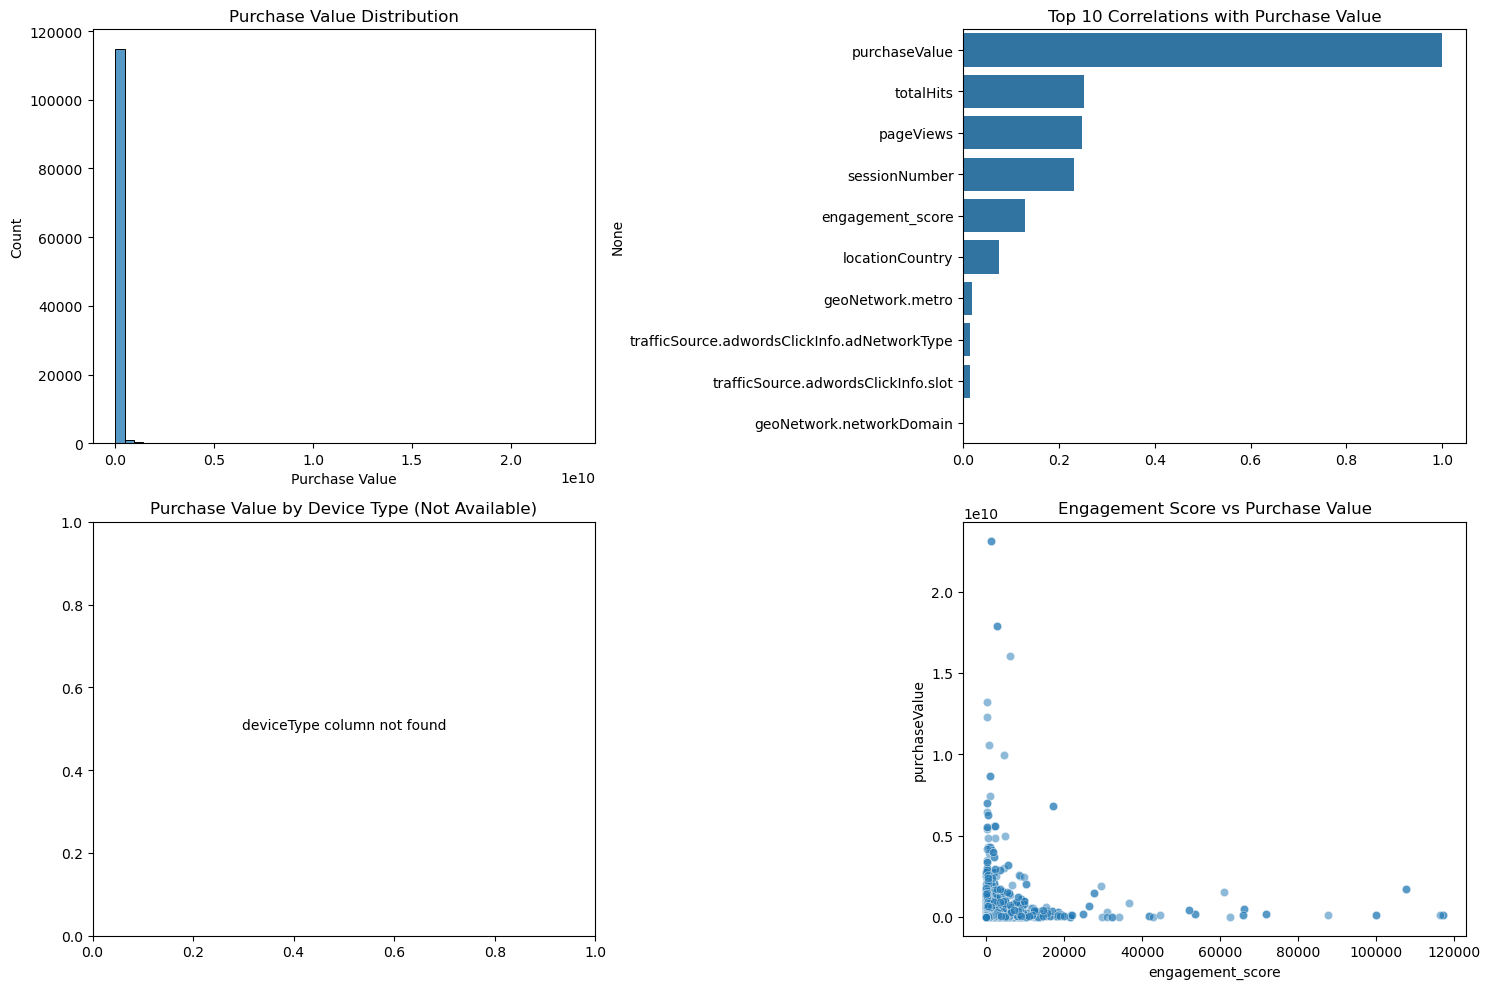


Available columns in the dataset:
['trafficSource.isTrueDirect', 'purchaseValue', 'browser', 'device.screenResolution', 'trafficSource.adContent', 'trafficSource.keyword', 'screenSize', 'geoCluster', 'trafficSource.adwordsClickInfo.slot', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'userId', 'trafficSource.campaign', 'device.mobileDeviceMarketingName', 'geoNetwork.networkDomain', 'gclIdPresent', 'device.operatingSystemVersion', 'sessionNumber', 'device.flashVersion', 'geoNetwork.region', 'trafficSource', 'totals.visits', 'geoNetwork.networkLocation', 'sessionId', 'os', 'geoNetwork.subContinent', 'trafficSource.adwordsClickInfo.isVideoAd', 'browserMajor', 'locationCountry', 'device.browserSize', 'trafficSource.adwordsClickInfo.adNetworkType', 'socialEngagementType', 'geoNetwork.city', 'trafficSource.adwordsClickInfo.page', 'geoNetwork.metro', 'pageViews', 'locationZone', 'device.mobileDeviceModel', 'trafficSource.referralPath', 'totals.bounces', 'date', 'device.languag

In [20]:
# Set up the plotting area
plt.figure(figsize=(15, 10))

# Plot 1: Purchase Value Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=train_data_engineered, x='purchaseValue', bins=50)
plt.title('Purchase Value Distribution')
plt.xlabel('Purchase Value')

# Plot 2: Correlation with Purchase Value
plt.subplot(2, 2, 2)
try:
    # Select only numeric columns for correlation
    numeric_cols = train_data_engineered.select_dtypes(include=[np.number]).columns
    numeric_df = train_data_engineered[numeric_cols]
    top_corr = numeric_df.corr()['purchaseValue'].sort_values(ascending=False)[:10]
    sns.barplot(x=top_corr.values, y=top_corr.index)
    plt.title('Top 10 Correlations with Purchase Value')
except Exception as e:
    print(f"Error in correlation plot: {e}")
    plt.text(0.5, 0.5, 'Error calculating correlations', ha='center')

# Plot 3: Average Purchase Value by Device Type
plt.subplot(2, 2, 3)
if 'deviceType' in train_data_engineered.columns:
    sns.boxplot(data=train_data_engineered, x='deviceType', y='purchaseValue')
    plt.xticks(rotation=45)
    plt.title('Purchase Value by Device Type')
else:
    plt.text(0.5, 0.5, 'deviceType column not found', ha='center')
    plt.title('Purchase Value by Device Type (Not Available)')

# Plot 4: Engagement Score vs Purchase Value
plt.subplot(2, 2, 4)
if 'engagement_score' in train_data_engineered.columns:
    sns.scatterplot(data=train_data_engineered, x='engagement_score', y='purchaseValue', alpha=0.5)
    plt.title('Engagement Score vs Purchase Value')
else:
    plt.text(0.5, 0.5, 'engagement_score column not found', ha='center')
    plt.title('Engagement Score vs Purchase Value (Not Available)')

plt.tight_layout()
plt.show()

# Print column info for debugging
print("\nAvailable columns in the dataset:")
print(train_data_engineered.columns.tolist())

## 6. Model Training

Let's prepare our data and train a Random Forest model.

In [21]:
# Prepare features and target
X = train_data_engineered.drop(['purchaseValue', 'userId', 'sessionId'], axis=1)
y = train_data_engineered['purchaseValue']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print('Model training completed!')

Model training completed!


## 7. Model Evaluation

Let's evaluate our model's performance using various metrics.

Model Performance Metrics:
RMSE: 203759395.19
MAE: 25936088.73
R2 Score: 0.12


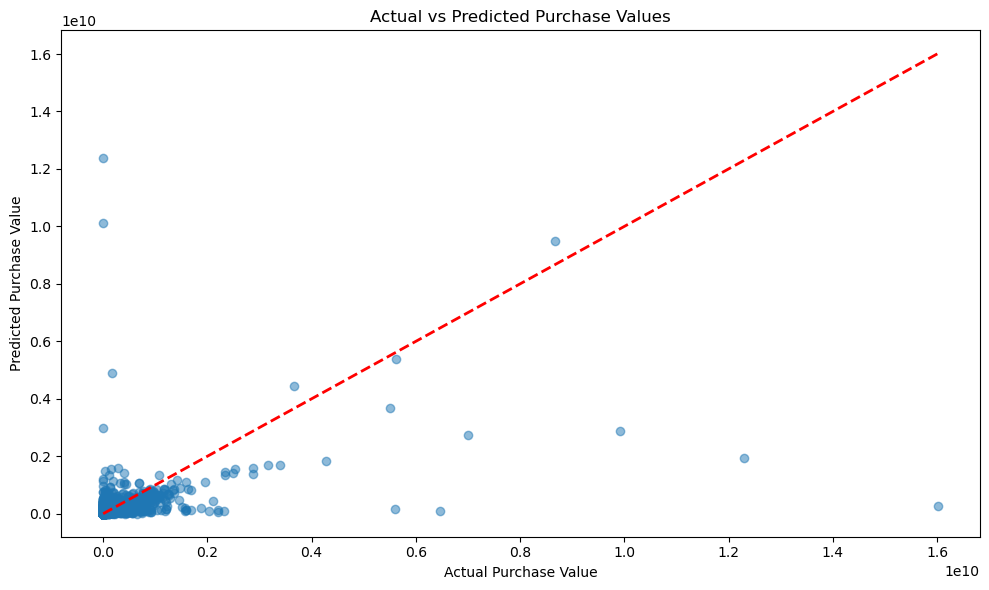

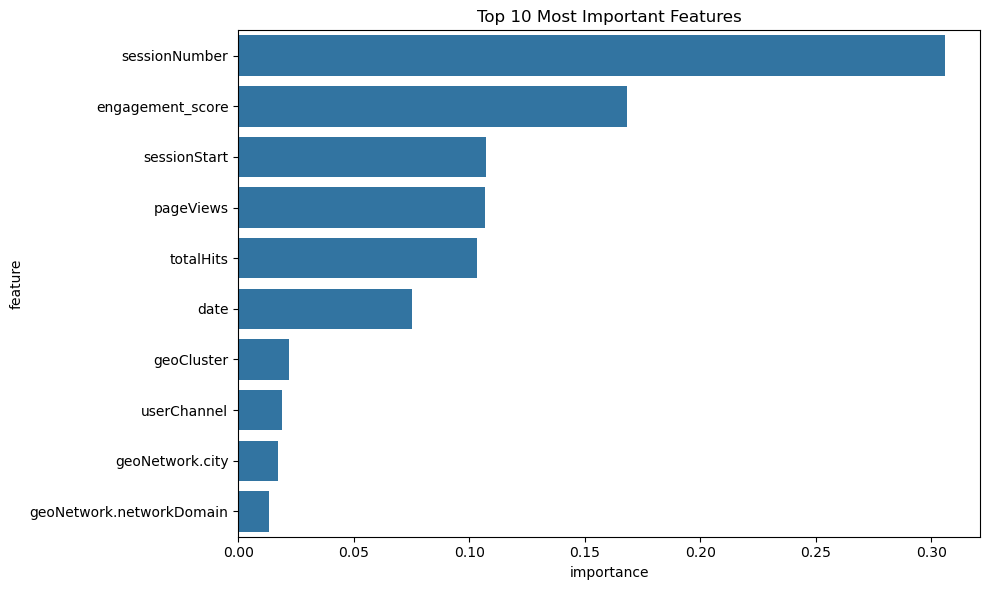

In [22]:
# Make predictions
y_pred = rf_model.predict(X_val_scaled)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('Model Performance Metrics:')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'R2 Score: {r2:.2f}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Purchase Value')
plt.ylabel('Predicted Purchase Value')
plt.title('Actual vs Predicted Purchase Values')
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

## 8. Predictions and Submission

Let's generate predictions for the test data and create a submission file.

In [23]:
# Preprocess test data
test_data_processed = preprocess_data(test_data.copy())
test_data_engineered = engineer_features(test_data_processed)

# Print the differences in columns between train and test data
train_cols = set(X.columns)
test_cols = set(test_data_engineered.columns) - {'userId', 'sessionId'}
print("Columns only in training data:", train_cols - test_cols)
print("Columns only in test data:", test_cols - train_cols)

# Ensure test data has the same columns as training data
for col in train_cols:
    if col not in test_data_engineered:
        test_data_engineered[col] = 0  # Add missing columns with default value 0

# Prepare test features with the same columns as training data
X_test = test_data_engineered[X.columns]  # Use same column order as training data
X_test_scaled = scaler.transform(X_test)

# Generate predictions
test_predictions = rf_model.predict(X_test_scaled)

# Create submission file
submission = pd.DataFrame({
    'sessionId': test_data['sessionId'],
    'purchaseValue': test_predictions
})

# Save submission file
submission.to_csv('submission.csv', index=False)
print('\nSubmission file created successfully!')
print('\nFirst few rows of predictions:')
print(submission.head())

# Print basic statistics of predictions
print('\nPrediction Statistics:')
print(pd.Series(test_predictions).describe())

Missing values:
totals.bounces                                  17274
new_visits                                       8912
pageViews                                           3
trafficSource.adContent                         28247
trafficSource.adwordsClickInfo.adNetworkType    27899
trafficSource.adwordsClickInfo.isVideoAd        27899
trafficSource.adwordsClickInfo.page             27899
trafficSource.adwordsClickInfo.slot             27899
trafficSource.isTrueDirect                      18245
trafficSource.keyword                           17962
trafficSource.referralPath                      18395
dtype: int64
Columns only in training data: set()
Columns only in test data: set()
Columns only in training data: set()
Columns only in test data: set()

Submission file created successfully!

First few rows of predictions:
    sessionId  purchaseValue
0  1494262567      5352400.0
1  1491433811       469800.0
2  1489001815            0.0
3  1510593024            0.0
4  1481559809       2